## Evaluations using the "super" dataset, to plot some dependencies on exponents, models or noise

In [1]:
#imports
import numpy as np
from tqdm import tqdm

import torch
from torch.optim import lr_scheduler
from swag.posteriors import swag as swag

from load_andi_dataset import *
from LSTM_Neural_Network import *
from swag_lr_scheduler import *

from matplotlib import pyplot as plt

In [2]:
dim = int(input("which dimension 1 or 2 ?"))
# Device configuration, run on gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters, neuralnet parameters need to match the loaded model! 
input_dim = dim # 1D input sequence
LSTM_size = [128,128,64]
output_dim = 2 #output size
batch_size = 500


number_swags = 5 #number of swag models in multi swag ensemble
number_mc_samples = 10 #number of samples taken per swag model

which dimension 1 or 2 ?1


In [3]:
modelint = int(input("Which model (0-4) of [attm,ctrw,fbm,lw,sbm]? "))
while modelint not in [0,1,2,3,4]:
    print("Please type an integer for model choice!")
    modelint = int(input("Which model (0-4) of [attm,ctrw,fbm,lw,sbm]?"))
#modelint = [2,4]

modelnames = ["attm","ctrw","fbm","lw","sbm"]
T = int(input("Trajectory Length? (10, 100 or 500) "))#100

#for i in range(len(modelint)):
#    print("Using model "+ modelnames[modelint[i]] + f" with length {T}")
print("Using model "+ modelnames[modelint] + f" with length {T}")

Which model (0-4) of [attm,ctrw,fbm,lw,sbm]? 4
Trajectory Length? (10, 100 or 500) 500
Using model sbm with length 500


In [4]:
#setup data using saved trajectories
noise_T = T
N_test = 40000#50000 #40k for only sub/super diffusive models; 50k for fbm/sbm
if modelint == 4 or modelint == 2:
    N_test = 50000
#if len(modelint) > 1: 
#  N_test = 40000
N_save = [2000,2000,2000,2000,2000]
task = 1
use_increments = True


test_path = "datasets/trajectories/validset/"
super_dataset = SingleModel_superdataset_from_saved_trajs(path = test_path, task = 1, dim = dim, N_total = N_test, 
                                                 T = T, N_save = N_save[modelint], use_increments = use_increments,model=modelint)


print(len(super_dataset))
#loader
super_loader = torch.utils.data.DataLoader(dataset=super_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Creating a dataset for task(s) [1] and dimension(s) [1].
Generating dataset for dimension 1.
50000


In [5]:
#check dataset example
ex_models,ex_exponents,ex_noise,ex_traj = iter(super_loader).next()
print(ex_models[0],ex_exponents[0],ex_noise[0],ex_traj[0][0:5])

tensor(4) tensor([0.3500]) tensor(0.5000) tensor([[-2.8916],
        [ 2.3901],
        [-1.9755],
        [ 2.8754],
        [ 0.0210]])


In [6]:
#load model:
#modelnaming = ""
#for i in range(len(modelint)):
#    modelnaming += modelnames[modelint[i]]
modelnaming = modelnames[modelint]
checkpoints_path = f"saves/aleatoric/"+modelnaming+f"/{T}_lenght/multi/"

#swag_model = swag.SWAG(LSTM_Regression_aleatoric, subspace_type = 'covariance', 
#                       subspace_kwargs={'max_rank': 20}, num_input_features = input_dim, 
#                      output_dim = output_dim, LSTM_size=LSTM_size)
#swag_model.to(device)

#swag_model.subspace.rank = torch.tensor(0)
#swag_model.load_state_dict(torch.load(checkpoint_path))

#swag_model.eval()

multi_swag_models = []
for i in range(number_swags):
    swag_model = swag.SWAG(LSTM_Regression_aleatoric, subspace_type = 'covariance', 
                       subspace_kwargs={'max_rank': 20}, num_input_features = input_dim, 
                      output_dim = output_dim, LSTM_size=LSTM_size)
    swag_model.to(device)
    swag_model.subspace.rank = torch.tensor(0)
    
    
    name = "swag_modelcheckpoint_multiswag%s" % i
    savefile = checkpoints_path + name
    
    swag_model.load_state_dict(torch.load(savefile,map_location=device))
    
    swag_model.eval()
    
    
    multi_swag_models.append(swag_model)


#mse loss and Gaussian negative log likelihood criterion
MSELoss = nn.MSELoss()
criterion = torch.nn.GaussianNLLLoss()

In [7]:
#test multi swag model on super data set
n_test_steps = len(super_loader)
n_total_samples = len(super_dataset)
number_swags = len(multi_swag_models)

target_values = torch.zeros(n_test_steps,batch_size).to(device)
pred_values = torch.zeros(n_test_steps,batch_size).to(device)
pred_std = torch.zeros(n_test_steps,batch_size).to(device)
all_models = np.array([])
all_noises = np.array([])


with torch.no_grad():
    n_abserr = 0
    n_samples = 0
    acc_loss = 0
    acc_pred_var = 0
    acc_mse = 0
    for j, (models, targets, noise, traj) in enumerate(tqdm(super_loader)):
        all_models = np.append(all_models,models)
        all_noises = np.append(all_noises,noise)
        traj = traj.to(device)
        targets = targets.to(device)
        
        output_samples = torch.ones(number_swags*number_mc_samples, len(traj), 1, dtype=torch.float32).to(device)
        variance_samples = torch.ones(number_swags*number_mc_samples, len(traj), 1, dtype=torch.float32).to(device)
        for k in range(number_swags):
            for i in range(number_mc_samples):
                multi_swag_models[k].sample()
                model_output = multi_swag_models[k](traj)
                output_samples[k*number_mc_samples+i] = model_output[:,0].view(-1,1)
                variance_samples[k*number_mc_samples+i] = model_output[:,1].view(-1,1)
        
        outputs = output_samples.mean(0)
        outputted_var = variance_samples.mean(0)
        combined_var = output_samples.var(0) + outputted_var
        
        target_values[j] = targets.view(len(traj))
        pred_values[j] = outputs.view(len(traj))
        pred_std[j] = torch.sqrt(combined_var).view(len(traj))
        
        acc_pred_var += combined_var.sum().item()
        """if epoch+1 >= swag_start:
            swag_model.set_swa()
            outputs = swag_model(traj)
        else:
            outputs = model(traj)"""
            
        acc_loss += criterion(outputs, targets, outputted_var).item()
        acc_mse += MSELoss(outputs,targets)
        n_samples += targets.size(0)
        n_abserr += (outputs-targets).abs().sum().item()
        

    MAE = n_abserr / n_samples
    mean_loss = acc_loss/n_test_steps
    mean_pred_var = acc_pred_var/n_samples
    mean_mse = acc_mse/n_test_steps
    print(f'MAE of the network on the 100000 test trajectories: {MAE}')
    print(f'Mean loss is: {mean_loss}')
    print(f'Mean Squared Error is: {mean_mse}')
    print(f'Mean Variance predicted by SWAG is: {mean_pred_var}')
    
target_values = target_values.view(-1).to("cpu")
pred_values = pred_values.view(-1).to("cpu")
pred_std = pred_std.view(-1).to("cpu")

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:09<00:00,  2.50s/it]

MAE of the network on the 100000 test trajectories: 0.07831368354797363
Mean loss is: -1.8770594775676728
Mean Squared Error is: 0.010661765933036804
Mean Variance predicted by SWAG is: 0.010807753610610963


In [8]:
plotdata = np.asarray([target_values.detach().numpy(),pred_values.detach().numpy(),pred_std.detach().numpy(),all_models,all_noises])
savename = f"plotdata/{dim}d_"+modelnaming+f"regression_length{T}"
if dim == 1:
    savename = f"plotdata/"+modelnaming+f"regression_length{T}"
np.savetxt(savename,plotdata)
print(savename)

plotdata/sbmregression_length500


In [9]:
print(all_models)

per_model_mse = np.zeros(5)
per_model_mae = np.zeros(5)
per_model_predvar = np.zeros(5)
model_count = np.zeros(5)

for i in tqdm(range(len(target_values))):
    per_model_mae[int(all_models[i])] += abs(target_values[i]-pred_values[i])
    per_model_mse[int(all_models[i])] += np.square(target_values[i]-pred_values[i])
    per_model_predvar[int(all_models[i])] += pred_std[i]**2
    model_count[int(all_models[i])] += 1
    
per_model_mae = per_model_mae/model_count
per_model_mse = per_model_mse/model_count
per_model_predvar = per_model_predvar/model_count

print(per_model_mae)
print(per_model_mse)
print(per_model_predvar)

[4. 4. 4. ... 4. 4. 4.]


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 14203.69it/s]

[      nan       nan       nan       nan 0.0783139]
[       nan        nan        nan        nan 0.01066173]
[       nan        nan        nan        nan 0.01080777]



/tmp/ipykernel_9965/2020429643.py:14: RuntimeWarning: invalid value encountered in true_divide
  per_model_mae = per_model_mae/model_count
/tmp/ipykernel_9965/2020429643.py:15: RuntimeWarning: invalid value encountered in true_divide
  per_model_mse = per_model_mse/model_count
/tmp/ipykernel_9965/2020429643.py:16: RuntimeWarning: invalid value encountered in true_divide
  per_model_predvar = per_model_predvar/model_count


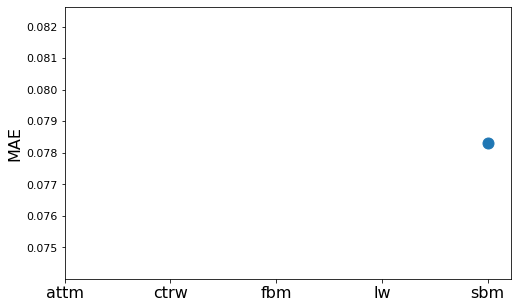

In [10]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

x_val = [0,1,2,3,4]
classes = ['attm', 'ctrw', 'fbm', 'lw', 'sbm']

plt.plot(x_val,per_model_mae,"o",ms = 11)
plt.xticks(ticks=x_val, labels=classes, size = 16)
plt.ylabel("MAE")

#plt.savefig("figs/super_evaluate/regression/MAE_per_model.png")
#plt.savefig("figs/super_evaluate/regression/MAE_per_model.svg")

#plt.savefig("figs/super_evaluate/regression/correctnoise/MAE_per_model.png")
#plt.savefig("figs/super_evaluate/regression/correctnoise/MAE_per_model.svg")
plt.show()

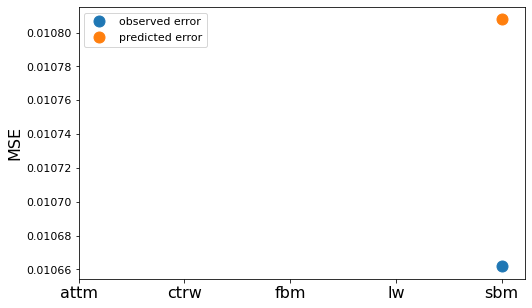

In [11]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

x_val = [0,1,2,3,4]
classes = ['attm', 'ctrw', 'fbm', 'lw', 'sbm']

plt.plot(x_val,per_model_mse,"o",ms = 11,label="observed error")
plt.plot(x_val,per_model_predvar,"o",ms = 11, label="predicted error")
plt.xticks(ticks=x_val, labels=classes, size = 16)
plt.ylabel("MSE")
plt.legend()


#plt.savefig("figs/super_evaluate/regression/MSE_per_model_with_pred.png")
#plt.savefig("figs/super_evaluate/regression/MSE_per_model_with_pred.svg")

#plt.savefig("figs/super_evaluate/regression/correctnoise/MSE_per_model_with_pred.png")
#plt.savefig("figs/super_evaluate/regression/correctnoise/MSE_per_model_with_pred.svg")
plt.show()

In [12]:
noises = [0.1,0.5,1]

per_noise_mse = np.zeros(3)
per_noise_mae = np.zeros(3)
per_noise_predvar = np.zeros(3)
noise_count = np.zeros(3)

for i in range(len(target_values)):
    index = int(2*all_noises[i]+0.1)
    
    per_noise_mae[index] += abs(target_values[i]-pred_values[i])
    per_noise_mse[index] += np.square(target_values[i]-pred_values[i])
    per_noise_predvar[index] += pred_std[i]**2
    noise_count[index] += 1
    
per_noise_mae = per_noise_mae/noise_count
per_noise_mse = per_noise_mse/noise_count
per_noise_predvar = per_noise_predvar/noise_count

print(per_noise_mae)
print(per_noise_mse)
print(per_noise_predvar)

[0.05403511 0.0763978  0.1041329 ]
[0.0046802  0.00949665 0.01770418]
[0.00493882 0.00962918 0.01775238]


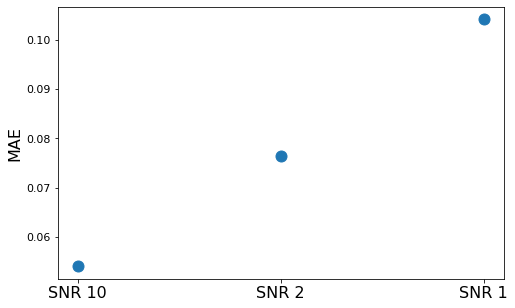

In [13]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

x_val = [0,1,2]
classes = ['SNR 10', 'SNR 2', 'SNR 1']

plt.plot(x_val,per_noise_mae,"o",ms = 11)
plt.xticks(ticks=x_val, labels=classes, size = 16)
plt.ylabel("MAE")

#plt.savefig("figs/super_evaluate/regression/MAE_per_noise.png")
#plt.savefig("figs/super_evaluate/regression/MAE_per_noise.svg")

#plt.savefig("figs/super_evaluate/regression/correctnoise/MAE_per_noise.png")
#plt.savefig("figs/super_evaluate/regression/correctnoise/MAE_per_noise.svg")
plt.show()

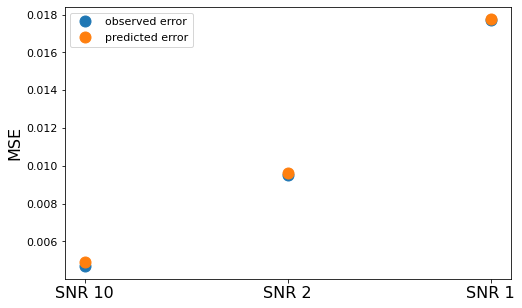

In [14]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

x_val = [0,1,2]
classes = ['SNR 10', 'SNR 2', 'SNR 1']

plt.plot(x_val,per_noise_mse,"o",ms = 11,label="observed error")
plt.plot(x_val,per_noise_predvar,"o",ms = 11, label="predicted error")
plt.xticks(ticks=x_val, labels=classes, size = 16)
plt.ylabel("MSE")
plt.legend()


#plt.savefig("figs/super_evaluate/regression/MSE_per_noise_with_pred.png")
#plt.savefig("figs/super_evaluate/regression/MSE_per_noise_with_pred.svg")

#plt.savefig("figs/super_evaluate/regression/correctnoise/MSE_per_noise_with_pred.png")
#plt.savefig("figs/super_evaluate/regression/correctnoise/MSE_per_noise_with_pred.svg")
plt.show()

In [15]:
#observed error over predicted error
predicted_errors = torch.arange(0.,1,0.02)
observed_errors = torch.zeros(len(predicted_errors))
n_interval = torch.zeros(len(predicted_errors))

for l in range(len(target_values)):
    index = torch.where(predicted_errors <= pred_std[l].item())[-1][-1]
    #print(index,pred_std[l]**2)
    n_interval[index] += 1
    observed_errors[index] += torch.square(target_values[l] - pred_values[l])

for l in range(len(predicted_errors)):
    if n_interval[l] > 50:
        observed_errors[l] = np.sqrt(observed_errors[l]/n_interval[l])
    else:
        observed_errors[l] = np.nan
print(observed_errors)

tensor([   nan, 0.0359, 0.0524, 0.0699, 0.0876, 0.1096, 0.1255, 0.1541, 0.1678,
        0.1880,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan])


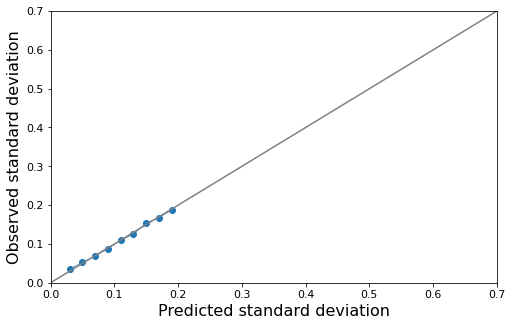

In [16]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  


plt.plot(predicted_errors+0.01,observed_errors,"o-",linewidth=0.7)
plt.plot(predicted_errors,predicted_errors,"grey")

plt.xlim(0,0.7)
plt.ylim(0,0.7)
#plt.legend()
plt.xlabel("Predicted standard deviation")
plt.ylabel("Observed standard deviation")

#plt.savefig("figs/super_evaluate/regression/conf_acc.png")
#plt.savefig("figs/super_evaluate/regression/conf_acc.svg")

#plt.savefig("figs/super_evaluate/regression/correctnoise/conf_acc.png")
#plt.savefig("figs/super_evaluate/regression/correctnoise/conf_acc.svg")

plt.show()

In [17]:
pred_values
target_values
pred_std
alpha_gts = torch.arange(0.05,2.05,0.05)
predval_per_gt_and_model = torch.zeros(5,len(alpha_gts))
predvar_per_gt_and_model = torch.zeros(5,len(alpha_gts))
ncount_per_gt_and_model = torch.zeros(5,len(alpha_gts))
for i in range(len(pred_values)):
    condition = target_values[i].item() - 0.025 <= alpha_gts
    index = torch.where(condition)[-1]
    if len(index) > 1:
        index = index[0]
    predval_per_gt_and_model[int(all_models[i]),index] += pred_values[i]
    predvar_per_gt_and_model[int(all_models[i]),index] += pred_std[i]**2
    ncount_per_gt_and_model[int(all_models[i]),index] += 1

    
predval_per_gt = predval_per_gt_and_model.sum(axis=0)/ncount_per_gt_and_model.sum(axis=0)
predvar_per_gt = predvar_per_gt_and_model.sum(axis=0)/ncount_per_gt_and_model.sum(axis=0)
print(predval_per_gt)
predval_per_gt_and_model = predval_per_gt_and_model/ncount_per_gt_and_model
predvar_per_gt_and_model = predvar_per_gt_and_model/ncount_per_gt_and_model

tensor([0.1170, 0.1450, 0.1788, 0.2132, 0.2551, 0.3028, 0.3478, 0.3995, 0.4536,
        0.5030, 0.5525, 0.6062, 0.6535, 0.7078, 0.7572, 0.8024, 0.8568, 0.9068,
        0.9550, 1.0108, 1.0575, 1.1074, 1.1620, 1.2135, 1.2654, 1.3070, 1.3628,
        1.4106, 1.4635, 1.5085, 1.5570, 1.6020, 1.6463, 1.6839, 1.7323, 1.7763,
        1.8100, 1.8390, 1.8700, 1.8892])


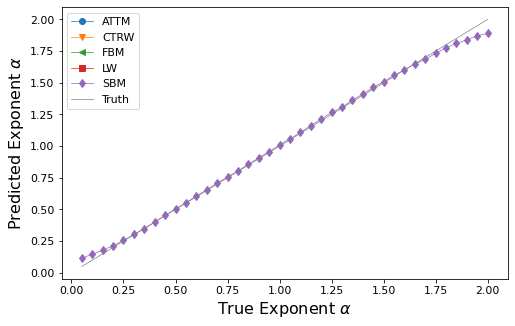

In [18]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  


plt.plot(alpha_gts ,predval_per_gt_and_model[0] ,"o-" ,markersize=6 ,linewidth=0.7 ,label="ATTM")
plt.plot(alpha_gts ,predval_per_gt_and_model[1] ,"v-" ,markersize=6 ,linewidth=0.7 ,label="CTRW")
plt.plot(alpha_gts ,predval_per_gt_and_model[2] ,"<-" ,markersize=6 ,linewidth=0.7 ,label="FBM")
plt.plot(alpha_gts ,predval_per_gt_and_model[3] ,"s-" ,markersize=6 ,linewidth=0.7 ,label="LW")
plt.plot(alpha_gts ,predval_per_gt_and_model[4] ,"d-" ,markersize=6 ,linewidth=0.7 , label="SBM")
plt.plot(alpha_gts ,alpha_gts ,"-" ,color="grey" ,markersize=7 ,linewidth=0.7 ,label="Truth")
plt.legend()
plt.xlabel("True Exponent "+r"$\alpha$")
plt.ylabel("Predicted Exponent "+r"$\alpha$")

#plt.savefig("figs/super_evaluate/regression/alphapred_over_gt.png")
#plt.savefig("figs/super_evaluate/regression/alphapred_over_gt.svg")

plt.show()

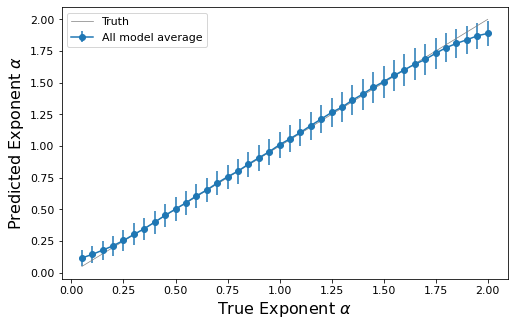

In [19]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

#print(predval_per_gt_and_model.mean(axis=1))

#plt.plot(alpha_gts ,predval_per_gt ,"o-" ,markersize=6 ,linewidth=0.7 ,label="all models")
plt.errorbar(alpha_gts,predval_per_gt,predvar_per_gt**(0.5),marker="o",label="All model average")
plt.plot(alpha_gts ,alpha_gts ,"-" ,color="grey" ,markersize=7 ,linewidth=0.7 ,label="Truth")
plt.legend()
plt.xlabel("True Exponent "+r"$\alpha$")
plt.ylabel("Predicted Exponent "+r"$\alpha$")

#plt.savefig("figs/super_evaluate/regression/alphapred_over_gt_all_models_errorbar.png")
#plt.savefig("figs/super_evaluate/regression/alphapred_over_gt_all_models_errorbar.svg")


plt.show()

In [20]:
#observed error over predicted error
predicted_errors = torch.arange(0.,1,0.02)
observed_errors = torch.zeros(len(predicted_errors))
n_interval = torch.zeros(len(predicted_errors))
n_interval_per_model = torch.zeros(5,len(predicted_errors))

for l in range(len(target_values)):
    index = torch.where(predicted_errors <= pred_std[l].item())[-1][-1]
    #print(index,pred_std[l]**2)
    n_interval[index] += 1
    observed_errors[index] += torch.square(target_values[l] - pred_values[l])
    n_interval_per_model[int(all_models[l]),index] += 1

for l in range(len(predicted_errors)):
    if n_interval[l] > 50:
        observed_errors[l] = np.sqrt(observed_errors[l]/n_interval[l])
    else:
        observed_errors[l] = np.nan
print(observed_errors)
print(n_interval_per_model)

tensor([   nan, 0.0359, 0.0524, 0.0699, 0.0876, 0.1096, 0.1255, 0.1541, 0.1678,
        0.1880,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

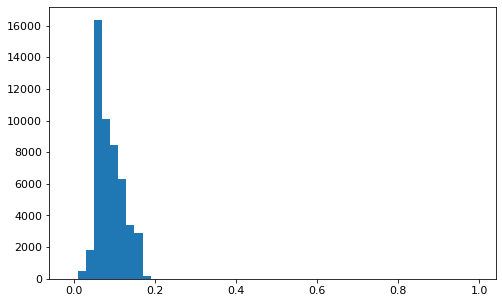

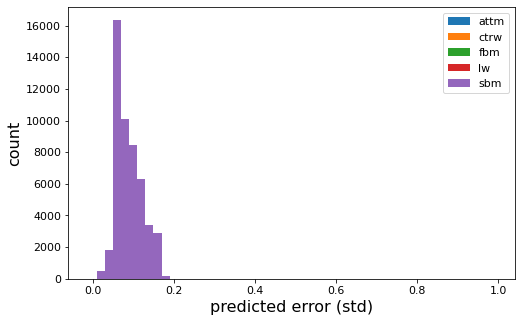

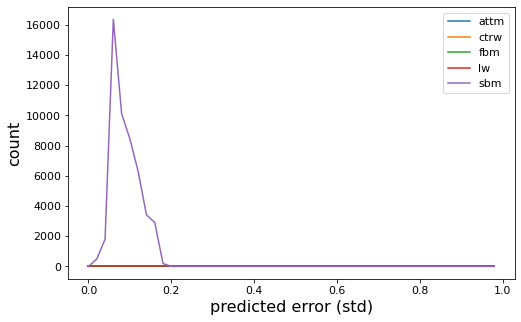

In [21]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16) 

models = ["attm","ctrw","fbm","lw","sbm"]
plt.bar(predicted_errors,n_interval,width=0.02)
plt.show()
y_offset = np.zeros((len(n_interval_per_model[0])))
for model in range(5):
    plt.bar(predicted_errors,n_interval_per_model[model],width=0.02,bottom=y_offset,label=models[model])
    y_offset = y_offset + np.asarray(n_interval_per_model[model])
plt.legend()
plt.xlabel("predicted error (std)")
plt.ylabel("count")
plt.show()
#plot only sbm,fbm
for model in range(5):
    plt.plot(predicted_errors,n_interval_per_model[model],label=models[model])
plt.legend()
plt.xlabel("predicted error (std)")
plt.ylabel("count")
plt.show()